In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/review-raw.csv').drop(columns=['Unnamed: 0'])
df.head()

,recommendationid,author_id,review,timestamp,voted_up,weighted_vote_score,app_id
0,186781078,76561197960432447,A legendary tactical shooter that shaped the g...,1738278781,True,0.652997,10
1,184974430,76561198071230926,"The best CS sure, but server browser is the il...",1736206418,True,0.581749,10
2,186584044,76561198206216352,Some of the best memories of my childhood were...,1738041574,True,0.628378,10
3,186564689,76561198110801124,This game feels so much better than CS2. I kno...,1738015332,True,0.000000,10
4,186418367,76561199813732773,its very fun to play you can make friends out ...,1737853720,True,0.000000,10


In [3]:
user_map = {u: i for i, u in enumerate(df["author_id"].unique())}
item_map = {i: j for j, i in enumerate(df["app_id"].unique())}

df["author_idx"] = df["author_id"].map(user_map)
df["app_idx"] = df["app_id"].map(item_map)
df['rating'] = (df['voted_up']).astype(int)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
class NCFDataset(Dataset):
    def __init__(self, dataframe):
        self.users = torch.tensor(dataframe['author_idx'].values, dtype=torch.long)
        self.items = torch.tensor(dataframe['app_idx'].values, dtype=torch.long)
        self.ratings = torch.tensor(dataframe['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

train_dataset = NCFDataset(df_train)
test_dataset = NCFDataset(df_test)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [5]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, mf_factors=8, mlp_layer_dims=[64, 32, 16, 8]):
        super(NCF, self).__init__()
        
        # Embedding layers
        self.mf_user_embedding = nn.Sequential(
            nn.Embedding(num_users, mf_factors),
            nn.Flatten()
        )
        
        self.mf_item_embedding = nn.Sequential(
             nn.Embedding(num_items, mf_factors),
             nn.Flatten()
        )
        
        self.mlp_user_embedding = nn.Sequential(
            nn.Embedding(num_users, int(mlp_layer_dims[0]/2)),
            nn.Flatten()
        )
         
        self.mlp_item_embedding = nn.Sequential(
            nn.Embedding(num_items, int(mlp_layer_dims[0]/2)),
            nn.Flatten()
        )

        # MLP layers
        mlp_layers = []
        for idx, dim in enumerate(mlp_layer_dims[:-1]):
            mlp_layers.append(nn.Linear(int(dim), int(mlp_layer_dims[idx + 1])))
            mlp_layers.append(nn.ReLU())
        self.mlp_layers = nn.Sequential(*mlp_layers)
        
        self.logit = nn.Linear(mf_factors + mlp_layer_dims[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user, item):
        mf_user_embed = self.mf_user_embedding(user)
        mf_item_embed = self.mf_item_embedding(item)
        
        mlp_user_embed = self.mlp_user_embedding(user)
        mlp_item_embed = self.mlp_item_embedding(item)

        mf_vector = torch.mul(mf_user_embed, mf_item_embed)
        mlp_vector = torch.concat([mlp_user_embed, mlp_item_embed], -1)
        mlp_vector = self.mlp_layers(mlp_vector)
        
        final_vector = torch.concat([mf_vector, mlp_vector], dim=-1)
        logit = self.logit(final_vector)
        output = self.sigmoid(logit)
        return output.view(-1)

In [6]:
num_users = df["author_idx"].max() + 1
num_items = df["app_idx"].max() + 1

model = NCF(num_users, num_items)

In [7]:
print(model)

NCF(
  (mf_user_embedding): Sequential(
    (0): Embedding(836887, 8)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (mf_item_embedding): Sequential(
    (0): Embedding(69001, 8)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_user_embedding): Sequential(
    (0): Embedding(836887, 32)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_item_embedding): Sequential(
    (0): Embedding(69001, 32)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_layers): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
  )
  (logit): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [8]:
learning_rate = 0.001
batch_size = 256
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.to(device)
    losses = []
    model.train()
    for batch, (users, items, ratings) in enumerate(dataloader):
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)

        pred = model(users, items)
        print(loss_fn)
        loss = loss_fn(pred, ratings)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Add batch's loss to the losses list
        losses.append(loss.item())
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(ratings)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    # Return the average loss of an epoch
    return sum(losses)/len(losses)


def test_loop(dataloader, model, loss_fn):
    model.eval()
    losses = []

    with torch.no_grad():
        for users, items, ratings in dataloader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            pred = model(users, items)
            loss = loss_fn(pred, ratings)
            losses.append(loss.item())
            
    avg_loss = sum(losses)/len(losses)
    print(f"Avg loss on test: {avg_loss:>8f} \n")
    return avg_loss

In [16]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train_loop(train_dataloader, model, loss_fn, optimizer))
    test_losses.append(test_loop(test_dataloader, model, loss_fn))
print("Done!")

Epoch 1
-------------------------------
BCELoss()
loss: 0.462327  [  256/1413154]
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss()
BCELoss(

KeyboardInterrupt: 

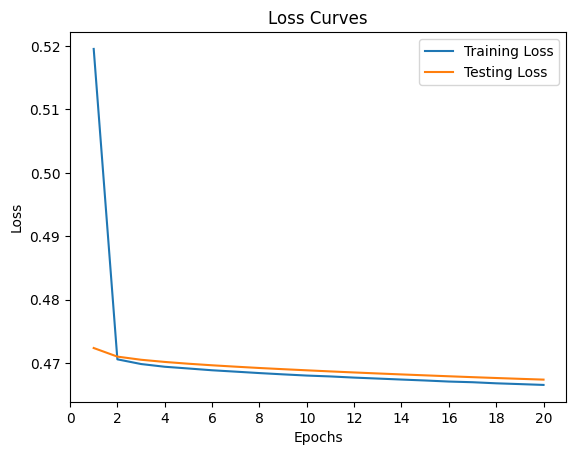

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Testing Loss")
plt.xticks(ticks=np.arange(0, epochs + 1, 2))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

In [ ]:
def predict(model, user, item):
    model.eval()
    user = torch.tensor([user], dtype=torch.long)
    item = torch.tensor([item], dtype=torch.long)
    with torch.no_grad():
        user = user.to(device)
        item = item.to(device)
        prediction = model(user, item).item()
    return prediction

# Predict for user 0 and item 0
print(predict(model, 0, 0))


0.7577460408210754


In [ ]:
user, item, rating = train_dataset.__getitem__(0)
print(user)

tensor(508)


In [ ]:
df[df['userIdx'] == user.item()]

,userId,movieId,rating,timestamp,userIdx,movieIdx,rating_bin
80373,509,1,4.0,1435992343,508,0,1
80374,509,5,1.5,1435992893,508,483,0
80375,509,13,3.0,1436101243,508,488,1
80376,509,17,3.0,1435992515,508,491,1
80377,509,19,4.0,1436027225,508,492,1
...,...,...,...,...,...,...,...
80835,509,129229,2.0,1435997905,508,8616,0
80836,509,130073,4.0,1435997996,508,8617,1
80837,509,133419,5.0,1435997941,508,2012,1
80838,509,136838,2.5,1435998776,508,8618,0


In [ ]:
df[df['movieIdx'] == item.item()]

,userId,movieId,rating,timestamp,userIdx,movieIdx,rating_bin
16493,105,7347,4.0,1447563002,104,4285,1
17482,111,7347,0.5,1516141332,110,4285,0
33468,226,7347,3.0,1097545796,225,4285,1
34269,232,7347,4.0,1096427389,231,4285,1
40127,274,7347,3.0,1171785570,273,4285,1
43034,288,7347,3.5,1092077405,287,4285,1
47469,307,7347,2.5,1186172692,306,4285,0
52165,339,7347,4.0,1460184528,338,4285,1
57553,380,7347,3.0,1494071470,379,4285,1
58401,381,7347,4.0,1168666051,380,4285,1


In [ ]:
df.iloc[:, 0]

0          186781078
1          184974430
2          186584044
3          186564689
4          186418367
             ...    
1766438    122460202
1766439    142446491
1766440     72576177
1766441    157067109
1766442    169036000
Name: recommendationid, Length: 1766443, dtype: int64